## Load the Simple Active Learning job from disk.

``retrained_params_job`` is the best ParAMS training job that was done during the Active Learning.

In [1]:
from scm.simple_active_learning import SimpleActiveLearningJob
from scm.params.plams.paramsjob import ParAMSJob
from scm.params import ResultsImporter, NoParameters
import scm.plams as plams
import os

# replace the path with your own path !
previous_sal_job_path = os.path.expandvars("$AMSHOME/examples/SAL/Output/SingleMolecule/plams_workdir/sal")
sal_job = SimpleActiveLearningJob.load_external(previous_sal_job_path)
retrained_params_job = sal_job.results.get_params_job()

## Get results for M3GNet-UP-2022 universal potential

Are the retrained results any better than those from the M3GNet-UP-2022 universal potential?

To find out, we need to evaluate the training and validation sets also with M3GNet-UP-2022. This can be done with the ParAMS "SinglePoint" task, which does not perform any parameter optimization but instead evaluates the training and validation sets with a given engine.

To set the engine settings, we need to call the ``set_extra_engine()`` method on the job collection and then store the results in a new folder that can be read by the new ParAMSJob. The easiest way to achieve this is to use the ``ResultsImporter`` class, even though we do not import any new results. When running the SinglePoint, we also have to explicitly specify that there are no parameters and store the ``NoParameters`` parameter interface:

In [4]:
m3gnet_up_s = plams.Settings()
m3gnet_up_s.input.MLPotential.Model = "M3GNet-UP-2022"
ri = ResultsImporter.from_params_results(retrained_params_job.results)
ri.job_collection.set_extra_engine(m3gnet_up_s)
print(ri.job_collection.engines)

---
Jobs: job_collection.yaml.gz
dtype: EngineCollection
version: '2024.101'
---
ID: 'ParAMS'
AMSInput: |
   Engine MLPotential
     Model M3GNet-UP-2022
   EndEngine
---
ID: 'forcefield;;type;UFF;'
AMSInput: |
   Engine forcefield
     type UFF
   EndEngine
...



In [5]:
pi = NoParameters()
folder = "m3gnet-up-data"
ri.store(folder, backup=False)  # will create the directory
pi.yaml_store(f"{folder}/parameter_interface.yaml")
os.listdir(folder)

['results_importer_settings.yaml',
 'validation_set.yaml',
 'job_collection_engines.yaml',
 'training_set.yaml',
 'parameter_interface.yaml',
 'job_collection.yaml']

We can now **initialize the new ParAMS SinglePoint job and run it**:

In [6]:
new_params_job = ParAMSJob.from_yaml(folder)
new_params_job.settings.input.Task = "SinglePoint"
new_params_job.name = "m3gnet-up"

plams.init(folder="plams_workdir_singlepoint_validation")
new_params_job.run();

PLAMS working folder: /home/hellstrom/adfhome/userdoc/Workflows/SimpleActiveLearning/PythonExamples/SALSingleMoleculeCompareToM3GNetUP2022/plams_workdir_singlepoint_validation
[12.02|15:31:23] JOB m3gnet-up STARTED
[12.02|15:31:23] JOB m3gnet-up RUNNING
[12.02|15:31:39] JOB m3gnet-up FINISHED
[12.02|15:31:39] JOB m3gnet-up SUCCESSFUL


### M3GNet-UP-2022 (predicted) forces vs. the reference (here UFF) forces

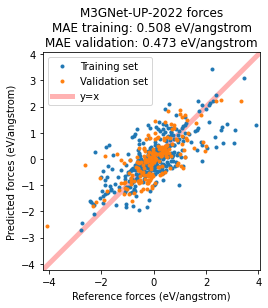

In [7]:
new_params_job.results.plot_simple_correlation("forces", source="best", title="M3GNet-UP-2022");

Here we can see that M3GNet-UP-2022 gives quite different force prediction compared to our chosen reference method (UFF force field).

Note that M3GNet-UP-2022 was trained to PBE DFT data, and the plot above shows the agreement to the UFF force field. The plot does not show the agreement to the PBE level of theory to which M3GNet-UP-2022 was originally trained!

### Retrained M3GNet (predicted) forces vs. the reference (here UFF) forces

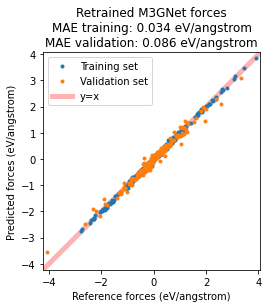

In [8]:
retrained_params_job.results.plot_simple_correlation("forces", source="best", title="Retrained M3GNet");

This is the same plot as shown in the previous tutorial. We can see that the active learning retraining has led to significant improvements in reproducing the reference data!